<a href="https://colab.research.google.com/github/MrLishu/PHM-Tongji/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys

sys.path.append(os.path.join(os.getcwd(), 'Mrlishu'))
if os.path.exists('/content'):
    os.chdir('/content')
    CODE_DIR = 'PHM-Tongji'
    if not os.path.exists(CODE_DIR):
        !git clone https://github.com/MrLishu/PHM-Tongji.git $CODE_DIR
    os.chdir(f'./{CODE_DIR}')

    # !git config --global user.email "2601165031@qq.com"
    # !git config --global user.name "MrLishu"

    # !pip install colabcode
    # from colabcode import ColabCode
    # ColabCode(port=10000)


Cloning into 'PHM-Tongji'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 113 (delta 45), reused 93 (delta 25), pack-reused 0
Receiving objects: 100% (113/113), 41.62 MiB | 21.56 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [2]:
import numpy as np
from preprocess import cwt


raw_data_directory = r'data/raw/PHM2010'
processed_data_directory = r'data/processed/PHM2010'

sampling_rate=50000

resample_number=1024
step=1

totalscale=256
wavename='morl'

c1_resample = np.load(r'data/processed/PHM2010/c1_1024_resample.npy')
c1_label = np.load(r'data/processed/PHM2010/c1_label.npy')
rs_rate = sampling_rate
c1_cwt = cwt(c1_resample, rs_rate, totalscale=totalscale, wavename=wavename, save=False)


Continuous wavelet transform... (315/315)
Continuous wavelet transform completed.


In [4]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split

In [5]:
class MyDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        return self.data[index], self.label[index]

In [19]:
x_train, x_test, y_train, y_test = train_test_split(c1_cwt[:, 3:6], c1_label[:, 1:].mean(axis=-1)[:, np.newaxis], test_size=0.1, random_state=99)
train_dataset = MyDataset(x_train, y_train)
test_dataset = MyDataset(x_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4)

In [20]:
model = models.resnet18(pretrained=False)
# model.conv1 = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
model.fc = nn.Linear(in_features=512, out_features=1, bias=True)

In [21]:
data, label = next(iter(train_dataloader))
data.shape, label.shape

(torch.Size([4, 3, 256, 1024]), torch.Size([4, 1]))

In [22]:
device = device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = None
num_epochs = 25

In [23]:
model.train()
loss_table = []

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    running_loss = 0.0

    # Iterate over data.
    for inputs, labels in train_dataloader:
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
      
    loss_table.append(running_loss)
    print(f'Running loss: {running_loss:.3f}')


Epoch 0/24
----------
Running loss: 528422.404
Epoch 1/24
----------
Running loss: 79456.736
Epoch 2/24
----------
Running loss: 19366.237
Epoch 3/24
----------
Running loss: 10858.281
Epoch 4/24
----------
Running loss: 7701.055
Epoch 5/24
----------
Running loss: 7593.939
Epoch 6/24
----------
Running loss: 7357.039
Epoch 7/24
----------
Running loss: 5195.502
Epoch 8/24
----------
Running loss: 3610.122
Epoch 9/24
----------
Running loss: 2873.862
Epoch 10/24
----------
Running loss: 3158.593
Epoch 11/24
----------
Running loss: 3645.774
Epoch 12/24
----------
Running loss: 2605.139
Epoch 13/24
----------
Running loss: 2106.493
Epoch 14/24
----------
Running loss: 1697.635
Epoch 15/24
----------
Running loss: 2229.811
Epoch 16/24
----------
Running loss: 1217.788
Epoch 17/24
----------
Running loss: 994.106
Epoch 18/24
----------
Running loss: 1532.105
Epoch 19/24
----------
Running loss: 1499.198
Epoch 20/24
----------
Running loss: 1094.010
Epoch 21/24
----------
Running loss: 864

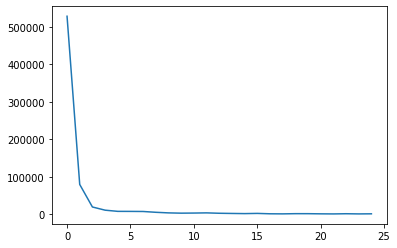

In [24]:
import matplotlib.pyplot as plt

plt.plot(loss_table)

In [39]:
model.eval()

label_table = []
predict_table = []

for inputs, labels in train_dataloader:
  inputs = inputs.float().to(device)
  labels = labels.float().to(device)

  outputs = model(inputs)

  label_table += labels.flatten().cpu().numpy().tolist()
  predict_table += outputs.flatten().cpu().detach().numpy().tolist()

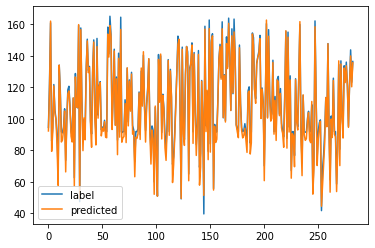

In [40]:
plt.plot(np.arange(len(label_table)), label_table, label='label')
plt.plot(np.arange(len(label_table)), predict_table, label='predicted')
plt.legend()

(array([  1.,   0.,   0.,   1.,  29., 115.,  73.,  34.,  23.,   7.]),
 array([-11.77549362,  -9.44236488,  -7.10923615,  -4.77610741,
         -2.44297867,  -0.10984993,   2.22327881,   4.55640755,
          6.88953629,   9.22266502,  11.55579376]),
 <a list of 10 Patch objects>)

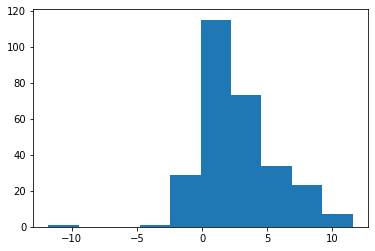

In [42]:
plt.hist(np.array(label_table) - np.array(predict_table))

(array([  1.,   0.,   0.,   0.,   0.,   2., 166.,  76.,  29.,   9.]),
 array([-0.29703451, -0.25098198, -0.20492944, -0.15887691, -0.11282437,
        -0.06677184, -0.02071931,  0.02533323,  0.07138576,  0.1174383 ,
         0.16349083]),
 <a list of 10 Patch objects>)

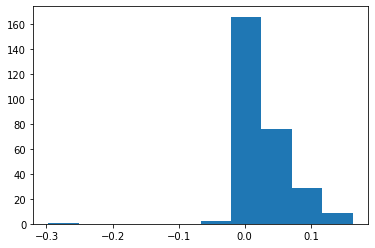

In [43]:
plt.hist((np.array(label_table) - np.array(predict_table)) / np.array(label_table))

In [44]:
(np.array(label_table) - np.array(predict_table)).std()

2.8655222841003485